# Implementación del algoritmo de optimización con enjambre de particulas

#### 1. Configuración, Librerías y Constantes

In [75]:
import numpy as np
import pandas as pd
import folium
from typing import List, Tuple

HUMEDAD_OPTIMA = {'Maíz': 30.0, 'Tomate': 40.0, 'Chile': 25.0}
ELEVACION_PROMEDIO = 30.0
DISTANCIA_MAX_COBERTURA = 0.5 
DISTANCIA_MIN_SENSORES = 0.05

#### 2. Carga y Exploración Inicial de Datos

In [76]:
df_cultivos = pd.read_excel('./Datos/DatosCultivos.xlsx')
print(df_cultivos.head())
print(f"\nDatos cargados: {len(df_cultivos)} puntos")
print(f"Cultivos: {df_cultivos['Cultivo'].unique()}")

   Humedad Cultivo  Elevación  Salinidad  Temperatura     Latitud    Longitud
0     35.4    Maíz       32.1       1.18          30.9  25.525269 -108.480884
1     20.0    Maíz       40.8       3.30          27.5  25.600618 -108.519701
2     43.3    Maíz       21.9       1.17          31.8  25.577411 -108.465669
3     36.3    Maíz       41.7       2.93          25.3  25.616337 -108.470516
4     17.3   Chile       31.8       1.91          29.1  25.522286 -108.480179

Datos cargados: 100 puntos
Cultivos: ['Maíz' 'Chile' 'Tomate']


#### 3. Visualización de los datos iniciales 

Muestra los puntos de cultivo en un mapa utilizando folium para visualizar la distribución de los datos.

In [77]:
# CREACIÓN Y PUNTOS DEL MAPA CON FOLIUM
map_center_lat = df_cultivos['Latitud'].mean()
map_center_lon = df_cultivos['Longitud'].mean()
map_center = [map_center_lat, map_center_lon]

cm = 0
cc = 0
ct = 0

# Inicializar el mapa
m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')

# Iterar y añadir marcadores de cultivo
for index, row in df_cultivos.iterrows():
    
    if row['Cultivo'] == 'Maíz':
        poptext = f"Maíz - Humedad: {row['Humedad']}%"
        cm += 1
        color = 'green'
    elif row['Cultivo'] == 'Chile':
        poptext = f"Chile - Humedad: {row['Humedad']}%"
        cc += 1
        color = 'red'
    elif row['Cultivo'] == 'Tomate':
        poptext = f"Tomate - Humedad: {row['Humedad']}%"
        ct += 1
        color = 'orange'
    else:
        color = 'blue'
    

    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        popup=poptext,
        radius=3,                        
        color=color,                    
        fill=True,
        fill_color=color,       
        fill_opacity=0.6                     
    ).add_to(m)

print(f"\nTotal Maíz: {cm}")
print(f"Total Chile: {cc}")
print(f"Total Tomate: {ct}")
# Mostrar el mapa en la notebook
m


Total Maíz: 35
Total Chile: 35
Total Tomate: 30


#### 4. Funciones para calculo de peso y distancias

In [78]:
def distancia_haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    RADIO_TIERRA = 6371  # Radio de la Tierra en km
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = (np.sin(dlat/2) * np.sin(dlat/2) + 
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2))
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return RADIO_TIERRA * c

def calcular_peso_punto(punto_datos: pd.Series) -> float:
    
    pesos_cultivos = {'Maíz': 1.0, 'Tomate': 1.2, 'Chile': 1.1}
    puntaje_humedad = abs(punto_datos['Humedad'] - HUMEDAD_OPTIMA.get(punto_datos['Cultivo'], 0.0))
    puntaje_salinidad = punto_datos['Salinidad']
    puntaje_elevacion = abs(punto_datos['Elevación'] - ELEVACION_PROMEDIO)
    
    # Fórmula de peso combinada
    peso = (pesos_cultivos.get(punto_datos['Cultivo'], 1.0) * 0.4 +
            puntaje_humedad * 0.3 +
            puntaje_salinidad * 0.2 +
            puntaje_elevacion * 0.1)
    
    return peso


#### 5. Clase del Algoritmo PSO

In [79]:
class PSOAgricola:

    def __init__(self, puntos_datos: pd.DataFrame, num_sensores: int, 
                 num_particulas: int = 30, iter_max: int = 100):
        self.puntos_datos = puntos_datos
        self.num_sensores = num_sensores
        self.num_particulas = num_particulas
        self.iter_max = iter_max
        
        # Parámetros PSO
        self.w = 0.7     # Inercia
        self.c1 = 1.7    # Cognitivo
        self.c2 = 1.7    # Social
        
        # coordenadas de la zona de estudio
        self.limites_lat = (25.52, 25.62)
        self.limites_lon = (-108.52, -108.42)
        
        self.inicializar_enjambre()

    def inicializar_enjambre(self):

        # Cada partícula tiene 2 * num_sensores dimensiones (Latitud, Longitud por sensor)
        self.posiciones = np.random.uniform(
            low=[self.limites_lat[0], self.limites_lon[0]] * self.num_sensores,
            high=[self.limites_lat[1], self.limites_lon[1]] * self.num_sensores,
            size=(self.num_particulas, 2 * self.num_sensores)
        )
        # Velocidades iniciales
        self.velocidades = np.random.uniform(
            low=-0.01, high=0.01, 
            size=(self.num_particulas, 2 * self.num_sensores)
        )
        # Mejores posiciones personales y puntajes
        self.mejores_posiciones_personales = self.posiciones.copy()
        self.mejores_puntajes_personales = np.full(self.num_particulas, -np.inf)
        
        # Mejor posición global y puntaje
        self.mejor_posicion_global = None
        self.mejor_puntaje_global = -np.inf

    def reformatear_a_sensores(self, posiciones_planas: np.ndarray) -> List[Tuple[float, float]]:
        return [(posiciones_planas[i], posiciones_planas[i+1]) 
                for i in range(0, len(posiciones_planas), 2)]

    def calcular_distancia_minima_sensores(self, sensores: List[Tuple[float, float]]) -> float:

        distancia_min = float('inf')
        for i in range(len(sensores)):
            for j in range(i+1, len(sensores)):
                dist = distancia_haversine(
                    sensores[i][0], sensores[i][1], 
                    sensores[j][0], sensores[j][1]
                )
                if dist < distancia_min:
                    distancia_min = dist
        return distancia_min

    def calcular_puntaje_cobertura(self, sensores: List[Tuple[float, float]]) -> float:

        puntaje_total = 0
        
        for sensor in sensores:
            puntaje_sensor = 0
            puntos_cubiertos = 0
            
            for _, punto in self.puntos_datos.iterrows():
                distancia = distancia_haversine(
                    sensor[0], sensor[1], punto['Latitud'], punto['Longitud']
                )
                
                if distancia <= DISTANCIA_MAX_COBERTURA:
                    peso = calcular_peso_punto(punto)
                    # Mayor calidad si la distancia es menor
                    calidad_cobertura = 1 - (distancia / DISTANCIA_MAX_COBERTURA)
                    puntaje_sensor += peso * calidad_cobertura
                    puntos_cubiertos += 1
            
            # Bonus por cubrir más puntos
            if puntos_cubiertos > 0:
                bonus_cobertura = puntos_cubiertos / len(self.puntos_datos)
                puntaje_sensor *= (1 + bonus_cobertura)
                
            puntaje_total += puntaje_sensor
        
        # Penalización por sensores muy cercanos
        distancia_minima = self.calcular_distancia_minima_sensores(sensores)
        if distancia_minima < DISTANCIA_MIN_SENSORES:
            puntaje_total *= 0.3
        
        return puntaje_total

    def evaluar_aptitud(self, posicion_particula: np.ndarray) -> float:

        try:
            sensores = self.reformatear_a_sensores(posicion_particula)
            return self.calcular_puntaje_cobertura(sensores)
        except Exception as e:
            return -np.inf 

    def actualizar_velocidades_y_posiciones(self):
    
        for i in range(self.num_particulas):
            r1, r2 = np.random.random(2)
            
            # Componentes de velocidad
            inercia = self.w * self.velocidades[i]
            cognitivo = self.c1 * r1 * (self.mejores_posiciones_personales[i] - self.posiciones[i])
            social = self.c2 * r2 * (self.mejor_posicion_global - self.posiciones[i])
            
            # Actualizar velocidad
            self.velocidades[i] = inercia + cognitivo + social
            
            # Actualizar posición
            self.posiciones[i] += self.velocidades[i]
            
            # Aplicar límites del espacio de búsqueda
            for j in range(0, 2 * self.num_sensores, 2):
                # Límites para latitud
                self.posiciones[i][j] = np.clip(
                    self.posiciones[i][j], self.limites_lat[0], self.limites_lat[1]
                )
                # Límites para longitud
                self.posiciones[i][j+1] = np.clip(
                    self.posiciones[i][j+1], self.limites_lon[0], self.limites_lon[1]
                )

    def verificar_convergencia(self, historial: List[float], criterio_iteraciones: int = 10) -> bool:

        if len(historial) < criterio_iteraciones:
            return False
        
        # Si no hay mejora significativa en las últimas 'criterio_iteraciones' iteraciones
        mejora_reciente = max(historial[-criterio_iteraciones:]) - min(historial[-criterio_iteraciones:])
        return mejora_reciente < 0.01

    def optimizar(self) -> dict:

        historial_convergencia = []
        
        for iteracion in range(self.iter_max):
            print(f"Iteración {iteracion + 1}/{self.iter_max}")
            
            # Evaluar todas las partículas
            for i in range(self.num_particulas):
                aptitud_actual = self.evaluar_aptitud(self.posiciones[i])
                
                # Actualizar mejor personal y global
                if aptitud_actual > self.mejores_puntajes_personales[i]:
                    self.mejores_posiciones_personales[i] = self.posiciones[i].copy()
                    self.mejores_puntajes_personales[i] = aptitud_actual
                
                if aptitud_actual > self.mejor_puntaje_global:
                    self.mejor_posicion_global = self.posiciones[i].copy()
                    self.mejor_puntaje_global = aptitud_actual
                    print(f"Nuevo mejor global: {self.mejor_puntaje_global:.4f}")
            
            self.actualizar_velocidades_y_posiciones()
            
            historial_convergencia.append(self.mejor_puntaje_global)
            
            # Criterio de parada temprana
            if self.verificar_convergencia(historial_convergencia):
                print("Convergencia alcanzada")
                break
        
        return {
            'mejores_posiciones': self.reformatear_a_sensores(self.mejor_posicion_global),
            'mejor_puntaje': self.mejor_puntaje_global,
            'historial_convergencia': historial_convergencia
        }

#### 6. Ejecución y resultados finales

In [80]:
# Configurar PSO
pso = PSOAgricola(
    puntos_datos=df_cultivos,
    num_sensores=100,           # Número de sensores a ubicar
    num_particulas=30,        # Tamaño del enjambre
    iter_max=30               # Número máximo de iteraciones
)

# Ejecutar optimización
resultado = pso.optimizar()

# Mostrar resultados finales
print(f"\n=== RESULTADOS FINALES ===")
print(f"Mejor puntaje: {resultado['mejor_puntaje']:.4f}")
print("Ubicaciones óptimas de sensores:")
for i, (lat, lon) in enumerate(resultado['mejores_posiciones']):
    print(f"Sensor {i+1}: Lat {lat:.6f}, Lon {lon:.6f}")

# Guardar la lista de ubicaciones óptimas para la visualización
mejores_posiciones_sensores = resultado['mejores_posiciones']
historial_convergencia = resultado['historial_convergencia']


Iteración 1/30
Nuevo mejor global: 33.0672
Nuevo mejor global: 131.6425
Nuevo mejor global: 140.9081
Nuevo mejor global: 148.0578
Iteración 2/30
Nuevo mejor global: 148.8413
Iteración 3/30
Nuevo mejor global: 153.9972
Iteración 4/30
Iteración 5/30
Iteración 6/30
Iteración 7/30
Iteración 8/30
Nuevo mejor global: 156.3296
Iteración 9/30
Nuevo mejor global: 158.5402
Iteración 10/30
Nuevo mejor global: 164.0800
Nuevo mejor global: 180.6878
Iteración 11/30
Iteración 12/30
Iteración 13/30
Iteración 14/30
Nuevo mejor global: 190.9685
Iteración 15/30
Iteración 16/30
Iteración 17/30
Iteración 18/30
Iteración 19/30
Iteración 20/30
Iteración 21/30
Iteración 22/30
Nuevo mejor global: 195.2375
Iteración 23/30
Iteración 24/30
Iteración 25/30
Nuevo mejor global: 197.9760
Iteración 26/30
Iteración 27/30
Iteración 28/30
Iteración 29/30
Nuevo mejor global: 202.9764
Iteración 30/30

=== RESULTADOS FINALES ===
Mejor puntaje: 202.9764
Ubicaciones óptimas de sensores:
Sensor 1: Lat 25.566465, Lon -108.50065

#### 7. Visualización de la solución óptima (mapa y convergencia)


Mapa final con ubicaciones óptimas de sensores y las ubicaciones originales


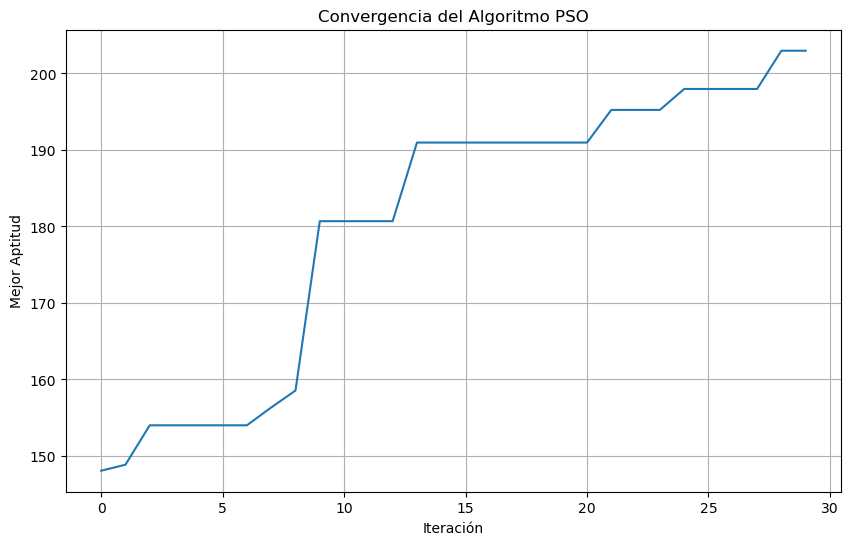

In [86]:
import matplotlib.pyplot as plt

# Añadir los sensores óptimos al mapa (m)
for sensor in mejores_posiciones_sensores:
    folium.CircleMarker(
        location=[sensor[0], sensor[1]],
        
        radius=2,                        
        color='blue',                    
        fill=True,
        fill_color='blue',       
        fill_opacity=0.8                     
    ).add_to(m)

# Mostrar el mapa final con los sensores
print("\nMapa final con ubicaciones óptimas de sensores y las ubicaciones originales")
display(m)

# Visualizar la convergencia
plt.figure(figsize=(10, 6))
plt.plot(historial_convergencia)
plt.title('Convergencia del Algoritmo PSO')
plt.xlabel('Iteración')
plt.ylabel('Mejor Aptitud')
plt.grid(True)
plt.show()

#### 8. Referencias
Yadav, A. (2023, March 30). Distance between two Geo-Locations in Python - AskPython. AskPython. https://www.askpython.com/python/examples/find-distance-between-two-geo-locations

Avitex. (2011, February 6). Haversine formula in Python (bearing and distance between two GPS points). Stack Overflow. https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points